# Machine Learning Engineer Nanodegree
## Capstone Project
Joaee Chew <br>
September 14, 2017

## I. Definition
_(approx. 1-2 pages)_

### Project Overview

AirBnb is a popular home-sharing platform, enabling people all over the world to lease or rent short-term lodgings. For potential hosts, this is a potentially lucrative option for their under-utilised vacation homes, spare rooms or even beds. However, it is difficult for new hosts to ascertain how much their property could earn them and whether it will be a worthy investment. Furthermore, how can they know the true value of their beloved penthouse adorned with designer furniture, compared to your run-of-the-mill IKEA filled apartment?

This project seeks to solve the problem by building a predictive model for the potential earnings of Airbnb listings, taking into account text descriptions to capture a rich and qualitative model of individual listings. While there are available commercial tools such as [AirSorted](http://www.airsorted.uk/) that predict Airbnb value, these models are generic with minimal features used and no indication of model accuracy. 

In addition, this project will implement an interpretability layer, using the [TreeInterpreter](https://github.com/andosa/treeinterpreter) package to decompose predictions into feature contribution components. This provides greater transparency and assurance to hosts that the nuances of their unique home has been captured by the model.

To build this model, I use the dataset provided by [Inside Airbnb](http://insideairbnb.com/get-the-data.html), where publicly available information about a city’s Airbnb’s listings have been scraped and released for independent, non-commercial use. This includes details about the listing such as no. of rooms, guests available, description, location as well as information about the yield such as price and no. of reviews.

Specifically, I will use the detailed listings information for London listings active from 3rd October 2016 – 4th March 2017. An active listing is defined as a property that has been reviewed at least once during this time period. After data cleaning, the dataset has 9722 rows and 16 columns. Importantly, the dataset contains the listings description as well as headers in text format that I will mine for qualitative predictors.

### Problem Statement

To build this model, the concept of yield is used as a proxy for potential future earnings. Yield is defined as the amount of revenue that a property will earn over a year. The calculation of yield uses Inside Airbnb’s ‘San Francisco Model’ based on price, average length of stay and review rate. A review rate of [50%](http://insideairbnb.com/about.html "Why 50% review rate is used") to convert reviews to estimated bookings. 

>**This project will predict the yield on prospective AirBnb listings in London and test whether text mining can lead to an increase in predictive accuracy.**

The intended workflow for this project is as follows:
1.	Read, clean and preprocess the data: <br>
    a.	Remove unnecessary features. This includes data that does not help with predicting yield, such as listing URL or scrape ID. <br>
    b.	Remove ‘leaking’ features. This includes data that should not be used to predict yield, such as ratings (which are not present at the point of listing), or the no. of other properties listed by the host (model should be built on the property only and not the host). <br>
    c.	Removing incomplete listings (e.g. listings with no price, or with availability less than 50% which indicates part-time listings that are not comparable). <br>
    d.	Impute missing values (e.g. using the most frequent or median where appropriate). <br>
2.	Build the model. I will use three models of increasing complexity, both to test for increase in predictive power but also to act as challenger models to the final model. <br>
    a.	I will begin with a simple linear regression to establish a benchmark accuracy. <br>
    b.	I propose the use of a decision tree as a next step. <br>
    c.	Finally, I will use a random forest ensemble model as the final model. <br>
4.	Feature engineering. This will be done iteratively with step 3, with new features tested for improvement in model accuracy. Potential ideas include: <br>
    a.	Using natural language techniques to extract features from the description. This involves the following NLP pipeline: <br>
        i.	Text data preparation (creating corpus, word stemming, creating document term matrix, removing sparse terms etc.) <br>
        ii.	Selection of features using bag-of-words and/or TF-IDF <br>
        iii.Use topic modelling to discover any natural topics in the listing descriptions <br>
    b.	Bucketing categorical features to reduce dimensionality (eg. Whole apartment vs. non-whole apartment instead of entire class size).
5.	Test the model. Here I will print final accuracy measures and produce insights such as feature importance.<br>
6.	Add interpretation layer to the final model. As a final step of the project, I will add an interpretation layer. This decomposes each prediction into feature contribution components for tree-based models, and helps improve transparency into model predictions. 

### Metrics

Mean squared error is used as the measure for model accuracy.  This measures the average of the square of the errors between the actual yield and predicted yield. The formula for this is as follows:

<img src="mse.svg">

MSE is a commonly used error score for regression models, and allows for an intuitive measure of error i.e. an MSE of 10000 indicates the yield model is off by £100 (square root of 10000). It is always non-negative, and values closer to zero are better. 

## II. Analysis
_(approx. 2-4 pages)_

#### Setting up

In [131]:
import pandas as pd
import os
import re
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [132]:
sns.set(style="ticks")
np.random.seed(sum(map(ord, "axis_grids")))
pd.options.display.max_columns = 20

#### Read data

In [133]:
dir_path = os.path.realpath('')

In [134]:
path = os.path.join(dir_path, 'data/listings_detailed.csv')
df = pd.read_csv(path, header=0, index_col=0)
print("Dataset has {} rows, {} columns.".format(*df.shape))

Dataset has 53904 rows, 94 columns.


//anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (88) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Data Exploration

In this section, you will be expected to analyze the data you are using for the problem. This data can either be in the form of a dataset (or datasets), input data (or input files), or even an environment. The type of data should be thoroughly described and, if possible, have basic statistics and information presented (such as discussion of input features or defining characteristics about the input or environment). Any abnormalities or interesting qualities about the data that may need to be addressed have been identified (such as features that need to be transformed or the possibility of outliers). Questions to ask yourself when writing this section:
- _If a dataset is present for this problem, have you thoroughly discussed certain features about the dataset? Has a data sample been provided to the reader?_
- _If a dataset is present for this problem, are statistics about the dataset calculated and reported? Have any relevant results from this calculation been discussed?_
- _If a dataset is **not** present for this problem, has discussion been made about the input space or input data for your problem?_
- _Are there any abnormalities or characteristics about the input space or dataset that need to be addressed? (categorical variables, missing values, outliers, etc.)_

The data set as scraped by Inside AirBnb is extremely comprehensive, containing 53904 rows and 94 columns. However, many of the data collected are unnecessary metadata (e.g. urls, id, pictures, host data), review data that causes leaking (e.g. review_scores), or has low relevance to the yield model (e.g. security_deposit, is_location_exact, notes). 

To keep the model manageable and effective, I will focus on the following features:
    1. 'name': Listing header text for text mining.
    2. 'description': Listing description text for text mining.
    3. 'property_type': Type of property e.g. apartment, house etc.
    4. 'room_type': Type of room e.g. private, shared etc.
    5. 'accommodates': No. of people the listing can accommodate.
    6. 'bathrooms': No. of bathrooms.
    7. 'bedrooms': No. of bedrooms.
    8. 'beds': No. of beds.
    9. 'square_feet': Size of listing.
    10. 'price': Price of listing.
    11. 'cleaning_fee': Cleaning fee.
    12. 'guests_included': No. of guests included in the base price.
    13. 'extra_people': Price for extra guests not included in the base price.
    14. 'minimum_nights': Minimum no. of nights required for booking.
    15. 'availability_365': No. of nights the listing is available for booking. (Note: This is a 'leaking' feature as listings may be unavailable as it is already booked and leaks the popularity. However, this needs to be used for filtering part-time listings and will be removed at a later stage.)
    16. 'reviews_per_month': Average no. of reviews listing receives per month. Used to calculate yield.
    17. 'latitude': Latitude of listing.
    18. 'longitude': Longitude of listing.
    
A sample of the reduced dataset along with summary statistics is shown below.

In [135]:
#Keep selected features

cols_to_keep = [
    'description', 
    'property_type', 'room_type', 'accommodates',
    'bathrooms', 'bedrooms', 'beds', 'square_feet',
    'price', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
    'availability_365', 'reviews_per_month', 'latitude', 'longitude', 'bed_type'
]
df = df[cols_to_keep]
print("Dataset has {} rows, {} columns.".format(*df.shape))
df.head()

Dataset has 53904 rows, 18 columns.


,description,property_type,room_type,accommodates,bathrooms,bedrooms,beds,square_feet,price,cleaning_fee,guests_included,extra_people,minimum_nights,availability_365,reviews_per_month,latitude,longitude,bed_type
id,,,,,,,,,,,,,,,,,,
15896822,"My place is close to TK Max, John Lewis, Marks...",Apartment,Private room,1,1.0,1.0,1.0,NaN,$23.00,NaN,1,$8.00,7,61,0.32,51.410036,-0.306323,Real Bed
4836957,This lovely spacious double bedroom is set in ...,Apartment,Private room,2,1.0,1.0,1.0,NaN,$50.00,NaN,1,$0.00,1,364,0.67,51.411482,-0.290704,Pull-out Sofa
13355982,"Spacious double bedroom, because of the light,...",Apartment,Private room,2,1.0,1.0,1.0,NaN,$24.00,NaN,1,$0.00,1,0,0.25,51.415851,-0.286496,Real Bed
13472704,"My place is good for couples, solo adventurers...",House,Private room,2,1.5,1.0,1.0,NaN,$50.00,NaN,1,$0.00,2,0,NaN,51.415723,-0.292246,Real Bed
17430865,very new decorated beautiful room and very com...,House,Private room,1,1.0,1.0,1.0,NaN,$25.00,NaN,1,$0.00,1,179,NaN,51.404285,-0.275426,Real Bed


In [136]:
# Clean numeric fields
num_feats = ['cleaning_fee', 'extra_people', 'price']
df[num_feats] = df[num_feats].replace('[\$,]', '', regex=True)
df[num_feats] = df[num_feats].apply(pd.to_numeric, errors='coerce')
print("Dataset has {} rows, {} columns.".format(*df.shape))

Dataset has 53904 rows, 18 columns.


In [137]:
df.describe()

,accommodates,bathrooms,bedrooms,beds,square_feet,price,cleaning_fee,guests_included,extra_people,minimum_nights,availability_365,reviews_per_month,latitude,longitude
count,53904.000000,53644.000000,53811.000000,53731.000000,582.000000,53904.000000,32483.000000,53904.000000,53904.000000,53904.000000,53904.000000,37438.000000,53904.000000,53904.000000
mean,3.036676,1.262751,1.353980,1.708027,577.508591,96.099622,37.115907,1.407428,6.686238,3.285229,155.849789,1.304307,51.510425,-0.127105
std,1.907429,0.547699,0.841912,1.201165,726.154243,117.641082,33.961914,1.040308,12.705758,28.536837,144.032928,1.459755,0.045454,0.088346
min,1.000000,0.000000,0.000000,0.000000,0.000000,8.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.010000,51.292892,-0.501305
25%,2.000000,1.000000,1.000000,1.000000,108.000000,42.000000,15.000000,1.000000,0.000000,1.000000,9.000000,0.300000,51.485099,-0.187191
50%,2.000000,1.000000,1.000000,1.000000,484.000000,70.000000,30.000000,1.000000,0.000000,2.000000,92.000000,0.770000,51.514730,-0.122403
75%,4.000000,1.500000,2.000000,2.000000,819.500000,119.000000,50.000000,1.000000,10.000000,3.000000,321.000000,1.800000,51.538943,-0.069183
max,16.000000,8.000000,10.000000,16.000000,10710.000000,7000.000000,517.000000,16.000000,240.000000,5000.000000,365.000000,16.870000,51.683101,0.317523


The summary statistics reveal certain interesting insights about the dataset, and these are explored individually below.

#### Removing part-time listings

An Airbnb host can setup a calendar for their listing so that it is only available for a few days or weeks a year. Other listings are available all year round (except for when it is already booked). For consistency, I will use Inside AirBnb's definition of highly available being >60 days a year.

I will remove part-time listings by removing availability <60 days a year, and also newly-listed listings with availability >300 days (using the other tail end as approximation).

The below distribution curve shows a bi-modal distribution for availability, demonstrating two concentrations of listing types. The lower availability peaks below 50 days indicating a part-time or non-committed listing, while the higher availability peaks at almost at the maximum 365 indicating a dedicated rental property.

Once used to clean the data, I will remove availability as it is a leaking feature. It reveals how many bookings there will be in the coming year.

Dataset has 18502 rows, 18 columns.
Dataset has 18502 rows, 17 columns.


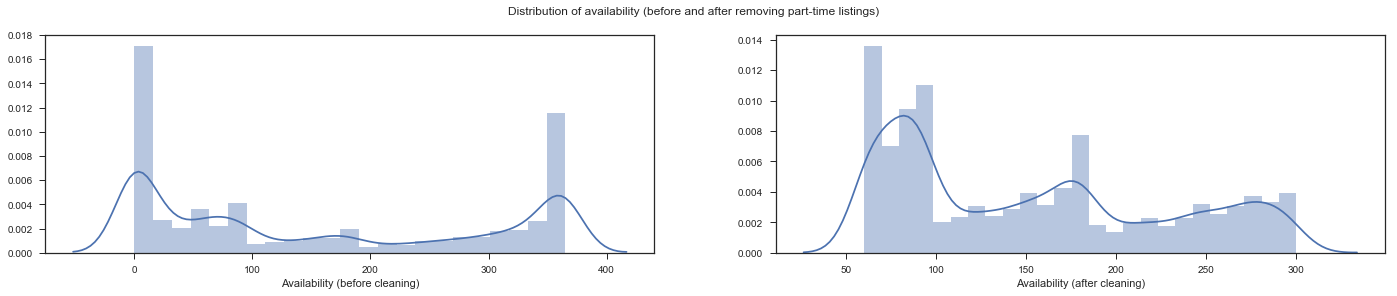

In [138]:
#Distribution of availability_365
%matplotlib inline

fig, axs = plt.subplots(ncols=2, figsize=(24, 4))
fig.suptitle('Distribution of availability (before and after removing part-time listings)')

# Before cleaning
x_axis=df['availability_365'].dropna()
sns.distplot(pd.Series(x_axis, name='Availability (before cleaning)'), ax=axs[0])

# Remove where availability less than 60 days or greater than 300 days
df = df.query('60 <= availability_365 <= 300')
print("Dataset has {} rows, {} columns.".format(*df.shape))

#After cleaning
x_axis=df['availability_365'].dropna()
sns.distplot(pd.Series(x_axis, name='Availability (after cleaning)'), ax=axs[1])
df = df.drop('availability_365', axis = 1)
print("Dataset has {} rows, {} columns.".format(*df.shape))

#### Removing large houses
For this model, I will remove extremely large rentals accommodating more than 10. The no. of persons a listing can accommodate will directly impact the calculation of yield, and whilst it is possible for a host to influence this number, this is less within their control and more an indicator of size. It is also unlikely that we have enough data to make tailored predictions for such listings.

You dropped 116 rows.
Dataset has 18386 rows, 17 columns.


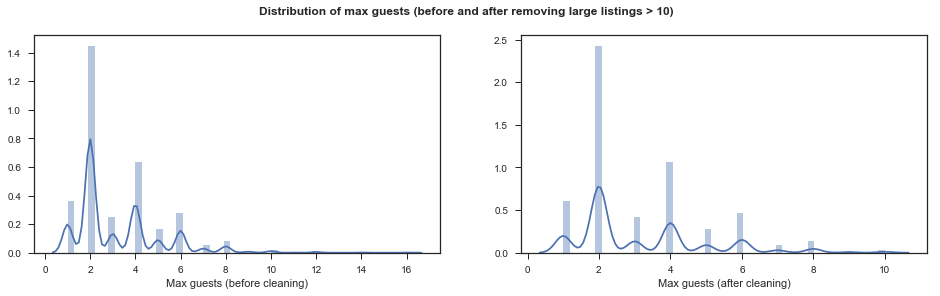

In [139]:
#Distribution of price
%matplotlib inline

fig, axs = plt.subplots(ncols=2, figsize=(16, 4))
fig.suptitle('Distribution of max guests (before and after removing large listings > 10)', weight='bold', fontsize=12)

# Before cleaning
x_axis=df['accommodates'].dropna()
sns.distplot(pd.Series(x_axis, name='Max guests (before cleaning)'), ax=axs[0])

# Remove where price > 1000
condition = df[df['accommodates'] > 10]
rows_to_drop = condition.index
print("You dropped {} rows.".format(condition.shape[0]))
df = df.drop(rows_to_drop, axis=0)
print("Dataset has {} rows, {} columns.".format(*df.shape))

#After cleaning
x_axis=df['accommodates'].dropna()
sns.distplot(pd.Series(x_axis, name='Max guests (after cleaning)'), ax=axs[1])

#### Removing high-priced rentals
The below distribution curve for price is right-skewed with a long tail of low frequency high-priced rentals. For this model, I will remove extremely high priced rentals above £1000/night to maintain comparability. It is also unlikely that we have enough data to make tailored predictions for such bespoke listings

You dropped 8 rows.
Dataset has 18378 rows, 17 columns.


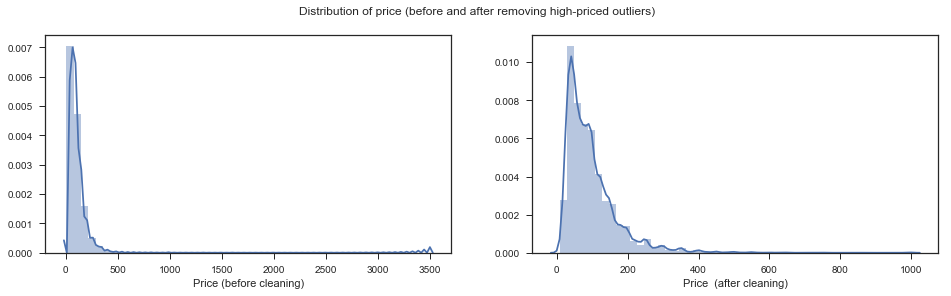

In [140]:
#Distribution of price
%matplotlib inline

fig, axs = plt.subplots(ncols=2, figsize=(16, 4))
fig.suptitle('Distribution of price (before and after removing high-priced outliers)')

# Before cleaning
x_axis=df['price'].dropna()
sns.distplot(pd.Series(x_axis, name='Price (before cleaning)'), ax=axs[0])

# Remove where price > 1000
condition = df[df['price'] > 1000]
rows_to_drop = condition.index
print("You dropped {} rows.".format(condition.shape[0]))
df = df.drop(rows_to_drop, axis=0)
print("Dataset has {} rows, {} columns.".format(*df.shape))

#After cleaning
x_axis=df['price'].dropna()
sns.distplot(pd.Series(x_axis, name='Price  (after cleaning)'), ax=axs[1])

#### Changing rare category types into 'other' bucket
For certain categories, we need to have a big enough sample set to ensure that it is statistically significant, i.e. the category is common enough to isolate correlation between that and predictor. This has an added benefit of reducing dimensionality. For property types, I create an 'Others' category for all except for the most common ones - Apartment, House and Bed & Breakfast.

In [141]:
df['property_type'].value_counts()

Apartment             13478
House                  4060
Bed & Breakfast         360
Townhouse               103
Loft                     85
Other                    83
Guesthouse               37
Serviced apartment       33
Dorm                     33
Boat                     32
Bungalow                 19
Condominium              18
Cabin                    16
Boutique hotel           10
Hostel                    4
Villa                     3
Chalet                    2
Lighthouse                1
Yurt                      1
Name: property_type, dtype: int64

In [142]:
categories_to_rename = ['Loft','Dorm','Guesthouse','Boutique hotel','Boat','Bungalow','Hostel',
                        'Cabin','Serviced apartment','Camper/RV','Villa','Condominium','Chalet','Parking Space',
                        'Tent','Yurt','Igloo','Ryokan (Japan)','Castle', 'Townhouse', 'Lighthouse']
df['property_type'].loc[df['property_type'].isin(categories_to_rename)] = 'Other'

//anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [143]:
categories_to_rename = ['Pull-out Sofa', 'Futon', 'Couch', 'Airbed']
df['bed_type'].loc[df['bed_type'].isin(categories_to_rename)] = 'Non-Real Bed'

//anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


#### Calculation of yield

As disuccsed earlier, **Yield** is defined as the amount of revenue that a property will earn over a year. This is calculated as follows:

> AVERAGE LENGTH OF STAY X PRICE X NO. OF REVIEWS/MTH X REVIEW RATE X 12 MONTHS

Using Inside AirBnb's San Franciso Model, an average length of stay in London is 3 nights with a review rate of 50%. Note that this is fairly conservative, and yield in reality is likely to be higher.

Analysing the distributions for price, reviews and resulting yield makes intuitive sense. The bulk of listings are less than £100/night probably for a private room, and receive 1-4 bookings a month for stays over the weekend. This indicates occupancy rates of 10-50%, earning the average AirBnb host £15,739 per listing in a year, going up to £21,480 for upper quartile listings.

Sense checking against the median [residential rents in Central London](https://www.london.gov.uk/what-we-do/housing-and-land/renting/london-rents-map, "London Rent Map by Mayor of London office") of £7,800 also supports the numbers.

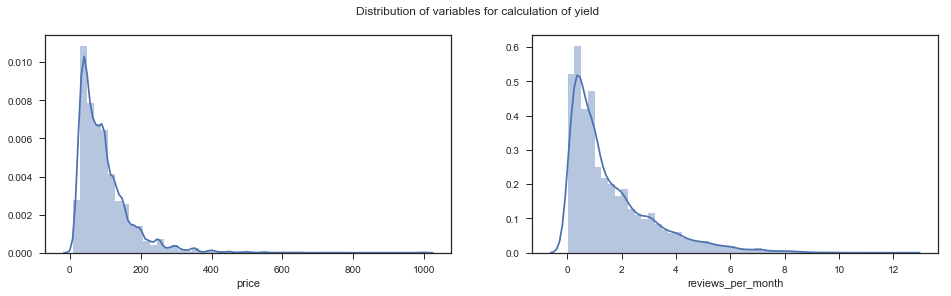

In [144]:
#Distribution of yield, availability_365, reviews_per_month
%matplotlib inline

fig, axs = plt.subplots(ncols=2, figsize=(16, 4))
fig.suptitle('Distribution of variables for calculation of yield')
x_axis=df['price'].dropna()
sns.distplot(pd.Series(x_axis, name=x_axis.name), ax=axs[0])
x_axis=df['reviews_per_month'].dropna()
sns.distplot(pd.Series(x_axis, name=x_axis.name), ax=axs[1])

In [145]:
# Calculate yield

# Average length of stay (by city) X Price ('price') X No. of reviews('reviews_per_month') / Review rate('50%')
avg_length_of_stay_london = 3
review_rate = 0.5
df['price'] = df['price'] + df['cleaning_fee']
df['yield'] = avg_length_of_stay_london * df['price'] * (df['reviews_per_month'] / review_rate) * 12

cols_to_drop = ['cleaning_fee']
df = df.drop(cols_to_drop, axis = 1)
print("Dataset has {} rows, {} columns.".format(*df.shape))

Dataset has 18378 rows, 17 columns.


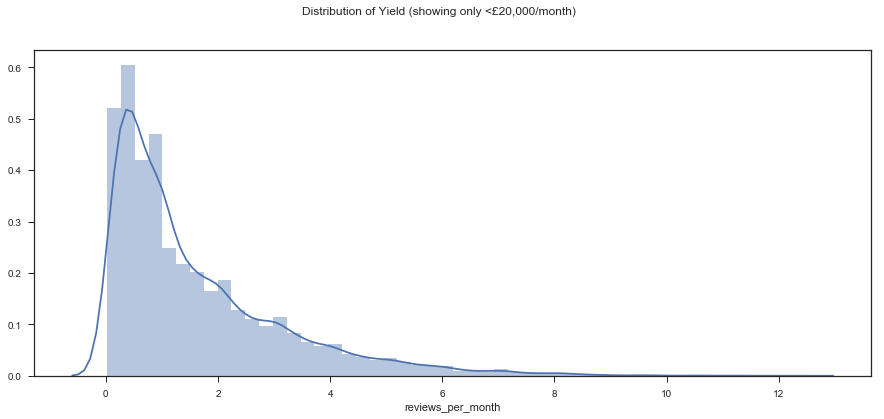

In [146]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15,6))
fig.suptitle('Distribution of Yield (showing only <£20,000/month)')
x_axes = df['yield'].dropna()
x = pd.Series(x_axis, name=x_axis.name)
ax = sns.distplot(x)

In [147]:
df['yield'].describe()

count      9722.000000
mean      15739.358560
std       17900.206348
min          82.080000
25%        3830.400000
50%        9288.000000
75%       21480.660000
max      250560.000000
Name: yield, dtype: float64

#### Missing values

A preview of the dataset above shows that there are missing values in some of the features such as 'beds', 'price' and 'reviews_per_month'. Depending on the nature of the column, we will treat missing values differently.

In 'square_feet', almost 90% of the rows are missing and I will choose to remove the feature completely

As 'yield' is an important target variable, I will completely remove any rows that have this datum missing. This will also take care of 'price' and 'reviews_per_month' as those are the required data to calculate 'yield'.

For the remaining features with a small number of missing values, I impute the categorical features with the most frequent category and numericla features with the median.

In [148]:
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [149]:
# Remove missing yield values
df = df.dropna(subset=['yield'])

# Remove square_feet as it is too sparse.
df = df.drop('square_feet', axis=1)

# Impute most frequent for categorical features
categorical_feats = df.select_dtypes(include=['object']).columns
df[categorical_feats] = DataFrameImputer().fit_transform(df[categorical_feats])

# Impute median for numerical features
num_feats = df.select_dtypes(include=[np.number]).columns
imp = Imputer(missing_values=np.nan, strategy='median', axis=0)
df[num_feats] = imp.fit_transform(df[num_feats])

print("Dataset has {} rows, {} columns.".format(*df.shape))

Dataset has 9722 rows, 16 columns.


In [150]:
df.isnull().values.any()

False

#### Topic modelling (Description)

For textual information, we use a Natural Language Processing pipeline to convert the corpus into a Document-Term-Matrix, whereby each listing (document) consists of a matrix of terms (processed words). With this in place, we can use Latent Dirichlet Allocation (LDA) to discover topics inherent in the corpus, classify the corpus according to the learned topics and use them as features for the regression model.<br><br>

<div class="alert alert-block alert-info">LDA is a generative Bayesian inference model that associates each document with a probability distribution over topics, where topics are probability distributions over words. It is an efficient way to analyse large volumes of text and is a more human interpretable method of topic modelling.</div>

In this project, I model the listing descriptions using LDA to explore emerging topics. The listing description field contains the bulk of the textual information found in a listing, and may contain important information that is not captured elsewhere. What emergent topics might we see from the rich text describing the history of a home, a host's beloved neighbourhood or it's carefully curated interiors?

In [151]:
# Seperate NLP features
nlp_feats = ['description']
corpus = df[nlp_feats]
df = df.drop(nlp_feats, axis = 1)
print("Dataset has {} rows, {} columns.".format(*df.shape))

Dataset has 9722 rows, 15 columns.


In [152]:
import nltk
nltk.data.path.append("/Users/joaeechew/dev/nltk_data")

from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.ldamodel import LdaModel

import itertools
from collections import Counter
from collections import defaultdict

import json
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [153]:
def preprocess_text(corpus):
    """Takes a corpus in list format and applies basic preprocessing steps of word tokenization,
     removing of english stop words, lower case and lemmatization."""
    processed_corpus = []
    english_words = set(nltk.corpus.words.words())
    english_stopwords = set(stopwords.words('english'))
    wordnet_lemmatizer = WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'[\w|!]+')
    for row in corpus:
        word_tokens = tokenizer.tokenize(row)
        word_tokens_lower = [t.lower() for t in word_tokens]
        word_tokens_lower_english = [t for t in word_tokens_lower if t in english_words or not t.isalpha()]
        word_tokens_no_stops = [t for t in word_tokens_lower_english if not t in english_stopwords]
        word_tokens_no_stops_lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in word_tokens_no_stops]
        processed_corpus.append(word_tokens_no_stops_lemmatized)
    return processed_corpus

In [154]:
def nlp_model_pipeline(processed_corpus):
    """Takes processed corpus and produce dictionary, doc_term_matrix and LDA model"""
    # Creates the term dictionary (every unique term in corpus is assigned an index)
    dictionary = Dictionary(processed_corpus)
    # Convert corpus into Document Term Matrix using dictionary prepared above
    doc_term_matrix = [dictionary.doc2bow(listing) for listing in processed_corpus]    
    return dictionary, doc_term_matrix

In [155]:
def LDA_topic_modelling(doc_term_matrix, dictionary, num_topics=3, passes=2):
    # Create an object for LDA model and train it on Document-Term-Matrix
    LDA = LdaModel
    ldamodel = LDA(doc_term_matrix, num_topics=num_topics, id2word = dictionary, passes=passes)
    return ldamodel

In [156]:
def add_topics_to_df(ldamodel, doc_term_matrix, df, new_col, num_topics):
    # Convert into Per-document topic probability matrix:
    docTopicProbMat = ldamodel[doc_term_matrix]
    docTopicProbDf = pd.DataFrame(index=df.index, columns=range(0, num_topics))
    for i, doc in enumerate(docTopicProbMat):
        for topic in doc:
            docTopicProbDf.iloc[i, topic[0]] = topic[1]
    docTopicProbDf[new_col] = docTopicProbDf.idxmax(axis=1)
    df_topics = docTopicProbDf[new_col]
    # Merge with df
    df_new = pd.concat([df, df_topics], axis=1)
    return df_new

In [157]:
corpus.head()

,description
id,
14912894,Lovely bright and sunny room overlooking the g...
14296637,My place is situated about 10-15mins walking d...
6222799,Sunny ensuite room in the newly converted loft...
7327883,Surbiton is very convenient for getting into ...
7515814,Our one bedroom apartment is a comfortable spa...


In [158]:
%%time
corpus_description = corpus['description'].astype(str)
processed_corpus_description = preprocess_text(corpus_description)
dictionary_description, doc_term_matrix_description = nlp_model_pipeline(processed_corpus_description)

CPU times: user 6.55 s, sys: 82.2 ms, total: 6.63 s
Wall time: 6.71 s


In [159]:
%%time
ldamodel_description = LDA_topic_modelling(doc_term_matrix_description, dictionary_description, num_topics=3, passes=1)

CPU times: user 24.3 s, sys: 39 ms, total: 24.3 s
Wall time: 24.3 s


### Exploratory Visualization

In this section, you will need to provide some form of visualization that summarizes or extracts a relevant characteristic or feature about the data. The visualization should adequately support the data being used. Discuss why this visualization was chosen and how it is relevant. Questions to ask yourself when writing this section:
- _Have you visualized a relevant characteristic or feature about the dataset or input data?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_

In [160]:
%%time
pyLDAvis.gensim.prepare(ldamodel_description, doc_term_matrix_description, dictionary_description)

CPU times: user 15.6 s, sys: 123 ms, total: 15.7 s
Wall time: 16.1 s


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      39.760756        1       1 -0.047150  0.017550
1      33.365182        1       2  0.000161 -0.035280
0      26.874062        1       3  0.046989  0.017731, topic_info=     Category          Freq        Term         Total  loglift  logprob
term                                                                   
6     Default   9090.000000   apartment   9090.000000  30.0000  30.0000
81    Default   8519.000000         bed   8519.000000  29.0000  29.0000
71    Default   6032.000000     station   6032.000000  28.0000  28.0000
98    Default   3989.000000       house   3989.000000  27.0000  27.0000
14    Default   7916.000000        walk   7916.000000  26.0000  26.0000
3     Default  10758.000000        room  10758.000000  25.0000  25.0000
101   Default   2621.000000      shower   2621.000000  24.0000  24.0000
542   Default    907.000000        oven    907.000000  23.0000  23.0000
260   Default   3442.000000           1   3442.000000  22.0000  22.0000
503   Default   1163.000000       check   1163.000000  21.0000  21.0000
4     Default   3616.000000      garden   3616.000000  20.0000  20.0000
135   Default   2646.000000        sofa   2646.000000  19.0000  19.0000
105   Default   7529.000000      double   7529.000000  18.0000  18.0000
185   Default    946.000000   microwave    946.000000  17.0000  17.0000
277   Default   1564.000000        line   1564.000000  16.0000  16.0000
100   Default   5060.000000       large   5060.000000  15.0000  15.0000
1178  Default    635.000000     freezer    635.000000  14.0000  14.0000
134   Default   3738.000000       space   3738.000000  13.0000  13.0000
199   Default   1718.000000       table   1718.000000  12.0000  12.0000
184   Default    536.000000         hob    536.000000  11.0000  11.0000
28    Default   8447.000000     kitchen   8447.000000  10.0000  10.0000
190   Default    566.000000     toaster    566.000000   9.0000   9.0000
150   Default   1051.000000       linen   1051.000000   8.0000   8.0000
189   Default    637.000000      kettle    637.000000   7.0000   7.0000
61    Default   2455.000000          10   2455.000000   6.0000   6.0000
187   Default   1713.000000     machine   1713.000000   5.0000   5.0000
3544  Default    774.000000       angel    774.000000   4.0000   4.0000
351   Default   1929.000000         min   1929.000000   3.0000   3.0000
211   Default   5465.000000      living   5465.000000   2.0000   2.0000
131   Default   1939.000000      minute   1939.000000   1.0000   1.0000
...       ...           ...         ...           ...      ...      ...
187    Topic3    889.666620     machine   1713.387532   0.6586  -5.3469
24     Topic3    683.016600    provided   1269.529895   0.6941  -5.6112
260    Topic3   1546.330997           1   3442.526392   0.5137  -4.7941
199    Topic3    871.717986       table   1718.018599   0.6355  -5.3673
356    Topic3    488.598613  dishwasher    851.364463   0.7587  -5.9462
105    Topic3   2772.240837      double   7529.089896   0.3149  -4.2103
3      Topic3   3431.981285        room  10758.403874   0.1715  -3.9968
186    Topic3    719.016734     washing   1442.117690   0.6180  -5.5598
100    Topic3   1806.815045       large   5060.505243   0.2841  -4.6384
28     Topic3   2603.216430     kitchen   8447.121071   0.1369  -4.2732
209    Topic3   1170.557760       fully   2939.471717   0.3933  -5.0725
331    Topic3    807.380298        free   1808.383396   0.5076  -5.4439
295    Topic3    955.300684         new   2316.057733   0.4284  -5.2757
29     Topic3   1790.365760    bathroom   5611.656926   0.1716  -4.6475
142    Topic3   1870.557910           2   6074.327309   0.1362  -4.6037
78     Topic3    861.647112      people   2011.153498   0.4664  -5.3789
172    Topic3   2003.121045     bedroom   8797.342607  -0.1657  -4.5353
211    Topic3   1454.221189      living   5465.293234  -0.0099  -4.8555
230    Topic3  

I chose to cluster the document terms into 3 topics as it was the largest number of topics that had no overlaps with very distinct topics. The separate topics also makes sense within the context of AirBnb listings.

Based on the top terms in each topic, the topics for listings could be described as:<br>

- Topic 1 - Apartments: This seems to focus on modern apartments, with words such as 'kitchen', 'bed', 'modern
 and 'space' standing out. This might appeal to younger travellers who want an apartment with modern facilities and furnishings. 
- Topic 2 - Location: This focuses on location with words such as 'location', 'business', 'station' and 'central'. This is likely to appeal to business travellers who value convenience and proximity to transport links.
- Topic 3 - Houses: This focuses on words associated with more traditional housing such as 'house', 'quiet', 'welcome' and 'clean'. This might appeal to families who want a larger space and prefer the safety of a residential neighbourhood.

### Algorithms and Techniques

In this section, you will need to discuss the algorithms and techniques you intend to use for solving the problem. You should justify the use of each one based on the characteristics of the problem and the problem domain. Questions to ask yourself when writing this section:
- _Are the algorithms you will use, including any default variables/parameters in the project clearly defined?_
- _Are the techniques to be used thoroughly discussed and justified?_
- _Is it made clear how the input data or datasets will be handled by the algorithms and techniques chosen?_

I intend to use 3 regression algorithms:

**1. Linear Regression**

To establish a baseline model

**2.	Decision Tree**

This is a more complex model that can capture nonlinear relationships in the dataset whilst still retaining interpretability. This is also robust to missing values, and has the added advantage of being able to help with feature selection based on feature importance. 

**3.	Random Forest**

This is the most complex ensemble model built from decision trees, and should be able to provide additional accuracy. While it sacrifices interpretability, sense checking can be made with the earlier decision tree model whilst added an interpretation layer using Tree Interpreter allows model users to break down individual predictions.


### Benchmark

In this section, you will need to provide a clearly defined benchmark result or threshold for comparing across performances obtained by your solution. The reasoning behind the benchmark (in the case where it is not an established result) should be discussed. Questions to ask yourself when writing this section:
- _Has some result or value been provided that acts as a benchmark for measuring performance?_
- _Is it clear how this result or value was obtained (whether by data or by hypothesis)?_

To my knowledge, there are no existing Airbnb pricing models released to the public. However, I will use a hold-out set to test my model, and the mean squared error will be used to measure the accuracy of the model. 

I will also build challenger models, and in particular start with a linear regression model to act as the baseline benchmark. A linear regression model is chosen as it is simple and interpretable, and the results can be easily interrogated. The methodology for building this model can be found below in the methodology section.

After building the model, an MSE of 254474109 with variance of 0.18 is established.

## III. Methodology
_(approx. 3-5 pages)_

### Data Preprocessing
In this section, all of your preprocessing steps will need to be clearly documented, if any were necessary. From the previous section, any of the abnormalities or characteristics that you identified about the dataset will be addressed and corrected here. Questions to ask yourself when writing this section:
- _If the algorithms chosen require preprocessing steps like feature selection or feature transformations, have they been properly documented?_
- _Based on the **Data Exploration** section, if there were abnormalities or characteristics that needed to be addressed, have they been properly corrected?_
- _If no preprocessing is needed, has it been made clear why?_

Before performing any machine learning, the dataset needs to be pre-processed. The following steps were taken for this project and discussed in the 'Data Exploration' section of the report:

1. Converting data types (e.g. string into integers)
2. Removing part-time listings
3. Removing large houses
4. Removing high-priced rentals
5. Changing minor category times into ‘Other’
6. Calculation of yield
7. Topic modelling

In addition to those steps already taken, missing values need to be imputed, features have to be selected and categorical features have to be encoded.

In [161]:
df.describe()

,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,minimum_nights,reviews_per_month,latitude,longitude,yield
count,9722.000000,9722.000000,9722.000000,9722.000000,9722.000000,9722.000000,9722.000000,9722.000000,9722.000000,9722.000000,9722.000000,9722.000000
mean,3.470582,1.267846,1.431393,1.894260,141.301893,1.681033,9.123637,3.473668,1.631914,51.509931,-0.130956,15739.358560
std,1.867488,0.517121,0.846198,1.212666,95.602315,1.235965,14.000453,10.015233,1.521587,0.039996,0.076983,17900.206348
min,1.000000,0.000000,0.000000,1.000000,17.000000,1.000000,0.000000,1.000000,0.020000,51.319567,-0.484704,82.080000
25%,2.000000,1.000000,1.000000,1.000000,70.000000,1.000000,0.000000,1.000000,0.490000,51.489270,-0.185451,3830.400000
50%,3.000000,1.000000,1.000000,2.000000,121.000000,1.000000,5.000000,2.000000,1.080000,51.513787,-0.130192,9288.000000
75%,4.000000,1.500000,2.000000,2.000000,180.000000,2.000000,15.000000,3.000000,2.300000,51.533126,-0.078512,21480.660000
max,10.000000,8.000000,7.000000,10.000000,1286.000000,10.000000,230.000000,300.000000,10.530000,51.663640,0.222488,250560.000000


#### Feature selection

I also remove features that are not necessary for the machine learning phase.

'Price' and 'reviews_per_month' are removed as they are used to calculate 'yield' and would have a strong correlation with 'yield'.

In [162]:
cols_to_drop = ['price', 'reviews_per_month']
df_final_viz = df[cols_to_drop]
df = df.drop(cols_to_drop, axis = 1)
print("Dataset has {} rows, {} columns.".format(*df.shape))

Dataset has 9722 rows, 13 columns.


#### Dummy encoding

Finally, categorical features need to be encoded to be treated properly by the machine learning algorithms. As the algorithms require numerical features only, the different categories have to be given a number. However, the categorical features present do not have any order inherent in them (eg. apartment vs. house) and thus needs to be encoded where 1 is given if the category is true and 0 is not.

In [166]:
# Dummy encoding
categorical_feats = ['property_type', 'room_type', 'bed_type']
df = pd.get_dummies(df, columns=categorical_feats, drop_first=False)
print("Dataset has {} rows, {} columns.".format(*df.shape))

Dataset has 9722 rows, 19 columns.


### Implementation
In this section, the process for which metrics, algorithms, and techniques that you implemented for the given data will need to be clearly documented. It should be abundantly clear how the implementation was carried out, and discussion should be made regarding any complications that occurred during this process. Questions to ask yourself when writing this section:
- _Is it made clear how the algorithms and techniques were implemented with the given datasets or input data?_
- _Were there any complications with the original metrics or techniques that required changing prior to acquiring a solution?_
- _Was there any part of the coding process (e.g., writing complicated functions) that should be documented?_

Once the dataset has been processed it is now ready to for the models to be built.

1. As a first step, the target variable 'yield' has to be seperated from the response variables to from the X and y data sets.
2. Both X and y data sets and respectively split into a training set and a testing set. I chose to use 30% of the data set for the testing set. As part of the splitting process, the data set is also shuffled to ensure there is no inherent or hidden order to the data set and that both the testing and training sets are a fair representative of the complete data set.
3. In the training phase, the training set is fitted to the 3 algorithms set out in the 'Algorithms and Techniques' section. During this process, the models are tuned using scikit-learn's GridSearchCV function. This allows us to set out a grid of parameters to iteratively train and set the models on and ultimately choose the best parameters. As tree-based algorithms are being applied, the parameters being tuned are the max no. of features used, the max depth of trees, the minimum sample split and the no. of trees grown (for random forest).
4. Once the 3 models have been fit, they are scored on the testing set. To do this, we predict the 'yield' variable using the trained models on the response data set. The predicted 'yield' values are scored against the actual 'yield' values in the test set using the mean squared error (MSE) as set out in the 'Metrics' section. Variance is also measured alongside MSE to have a better view of consistency of our models.
5. After each model is trained and tested, the results are compared to check that more complicated models do indeed produce a better accuracy.

In [34]:
df.head()

,accommodates,bathrooms,bedrooms,beds,guests_included,extra_people,minimum_nights,latitude,longitude,yield,property_type_Apartment,property_type_Bed & Breakfast,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Non-Real Bed,bed_type_Real Bed
id,,,,,,,,,,,,,,,,,,,
14912894,2.0,1.0,1.0,1.0,1.0,9.0,2.0,51.431117,-0.309713,2595.60,1,0,0,0,0,1,0,0,1
14296637,1.0,1.0,1.0,1.0,1.0,10.0,1.0,51.421323,-0.278367,807.84,1,0,0,0,0,1,0,0,1
6222799,3.0,1.0,1.0,1.0,1.0,10.0,1.0,51.419415,-0.288245,5113.44,0,0,1,0,0,1,0,0,1
7327883,2.0,1.0,1.0,1.0,1.0,10.0,1.0,51.390646,-0.310919,972.00,1,0,0,0,0,0,1,1,0
7515814,2.0,1.0,1.0,1.0,1.0,0.0,2.0,51.413554,-0.296376,12947.04,1,0,0,0,1,0,0,0,1


In [35]:
# Create response and target variable
target = 'yield'
X = df.drop(target, axis=1)
y = df[target]

In [36]:
# Train test split
test_size = 0.3
seed = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

#### Linear regression model

In [37]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [38]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [39]:
# Make predictions using the testing set
regr_y_pred = regr.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, regr_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, regr_y_pred))

Mean squared error: 254474109.10
Variance score: 0.18


#### Decision tree model

In [40]:
from sklearn.tree import DecisionTreeRegressor

In [41]:
# Fit regression model
dt_regr = DecisionTreeRegressor(random_state=seed, max_depth=5)
dt_regr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [42]:
# Make prediction
dt_y_pred = dt_regr.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, dt_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, dt_y_pred))

Mean squared error: 253282661.10
Variance score: 0.18


#### Random forest model

In [43]:
%%time
rf_regr = RandomForestRegressor(random_state=seed, bootstrap=True, criterion='mse', max_depth=10, 
                           max_features='auto', min_samples_split=4, n_estimators=150)

rf_regr.fit(X_train, y_train)

CPU times: user 2.13 s, sys: 12.3 ms, total: 2.14 s
Wall time: 2.15 s


In [44]:
# Make prediction
rf_y_pred = rf_regr.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, rf_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, rf_y_pred))

Mean squared error: 212548432.31
Variance score: 0.31


### Refinement
In this section, you will need to discuss the process of improvement you made upon the algorithms and techniques you used in your implementation. For example, adjusting parameters for certain models to acquire improved solutions would fall under the refinement category. Your initial and final solutions should be reported, as well as any significant intermediate results as necessary. Questions to ask yourself when writing this section:
- _Has an initial solution been found and clearly reported?_
- _Is the process of improvement clearly documented, such as what techniques were used?_
- _Are intermediate and final solutions clearly reported as the process is improved?_

In the 'Problem Statement' section, it was first highlighted that one of the key aspects of this project is to test the predictive value of textual information in AirBnb listings. As such, one of they key refinements made is to include the earlier topics that have been modelled using LDA (explained in the 'Data Exploration' section). Each listing is classified into one topic based on probability determined by the trained LDA model. This topic is then added in as a few feature.

Before this, the tuned random forest model had the best result with the lowest MSE of 212548432 and the highest variance of 0.31. After including the description topics, MSE reduces further to 211329730 while variance increases further to 0.32. This validates the hypothesis that there is valuable information as modelling description text as topics increases the model's predictive accuracy, although it is a very small effect.

In [167]:
df = add_topics_to_df(ldamodel_description, doc_term_matrix_description, df, new_col='topics_description', num_topics=3)

# Rename based on understanding of topics
df['topics_description'].replace({0:'Luxury', 1:'Business', 2:'Budget'},inplace=True)
df = pd.get_dummies(df, columns=['topics_description'], drop_first=False)

print("Dataset has {} rows, {} columns.".format(*df.shape))

Dataset has 9722 rows, 22 columns.


In [46]:
# Create response and target variable
X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [47]:
%%time
rf_regr.fit(X_train, y_train)

CPU times: user 2.31 s, sys: 9.99 ms, total: 2.32 s
Wall time: 2.33 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [48]:
# Make prediction
rf_y_pred = rf_regr.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, rf_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, rf_y_pred))

Mean squared error: 211329730.05
Variance score: 0.32


#### Tuning the final model

After confirming that including NLP features helps to improve accuracy, it is included in the final model. The parameters for the final Random Forest model is then tuned using scikit-learn's GridSearchCV.

A parameters grid of hyperparameters are created for GridSearchCV to iteratively use and test for the best cross-validated accuracy. The paramters being tuned are: Number of estimators, the maximum depth and the minimum samples split. After tuning, the best parameters are a max_depth of 15, minimum samples split of 10 and number of estimators 200.

The final MSE lowers to 200185564 with a variance score of 0.33. This shows that the model is fairly complex, with a large number of trees and depth.

In [56]:
#Tuning the model
param_grid = { "n_estimators"      : [175, 200, 225, 250],
           "criterion"         : ['mse'],
           "max_features"      : ['auto'], #auto, sqrt, log2, int/n_feature
           "max_depth"         : [10, 14, 15, 16, 18],
           "min_samples_split" : [6, 7, 8, 9, 10] ,
           "bootstrap": [True]}

In [57]:
%%time
rf = RandomForestRegressor(random_state=seed)

rf_cv = GridSearchCV(rf, param_grid, cv=5)
rf_cv.fit(X_train, y_train)

CPU times: user 34min 33s, sys: 31.8 s, total: 35min 5s
Wall time: 38min 26s


In [59]:
# Make prediction
rf_y_pred = rf_cv.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, rf_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, rf_y_pred))
# Best params
print("Tuned Model Parameters: {}".format(rf_cv.best_params_))

Mean squared error: 200185564.28
Variance score: 0.33
Tuned Model Parameters: {'bootstrap': True, 'criterion': 'mse', 'max_depth': 15, 'max_features': 'auto', 'min_samples_split': 8, 'n_estimators': 250}


## IV. Results
_(approx. 2-3 pages)_

### Model Evaluation and Validation
In this section, the final model and any supporting qualities should be evaluated in detail. It should be clear how the final model was derived and why this model was chosen. In addition, some type of analysis should be used to validate the robustness of this model and its solution, such as manipulating the input data or environment to see how the model’s solution is affected (this is called sensitivity analysis). Questions to ask yourself when writing this section:
- _Is the final model reasonable and aligning with solution expectations? Are the final parameters of the model appropriate?_
- _Has the final model been tested with various inputs to evaluate whether the model generalizes well to unseen data?_
- _Is the model robust enough for the problem? Do small perturbations (changes) in training data or the input space greatly affect the results?_
- _Can results found from the model be trusted?_

To test the robustness of the final model, sensitivity analysis is done by making adjustments to the inputs and evaluating the size of changes in the outputs. The adjustments tested are:

1. Changing the random state: This will cause different data points to be randomly selected during the train/testing split and during the random forest training process. By choosing different random states, we can ensure that model training is not a fluke and can be replicated on different states. Changing the state from 42 to 49, the MSE remains in the same ballpark at 211329730 and variance score is the same. 

2. Changing the split proportions between training and test set: By changing the amount of data split between training and testing, we can ensure that the model retains its accuracy on different size of testing data. A fairly conservative split of 30% for the test set had been chosen initially. By reducing this to 10%, the MSE drops to 205098824 which is to be expected. However, the change is not radicially different and the model is fairly robust. 

3. Changing input data: By manually tweaking some of the input data, it is possible to see how senstive the model is. If a small change in inputs lead to an unrealistic change in outputs then the model is unlikely to be robust. As an example, I take a random data point in the test data set and change the 'accommodates' feature which is one of the most significant features. The data point originally accommodates 4 persons and the model predicts a yield of £17,400 annually. Adjusting it to accommodate for 2 reduces the predicted yield to £13,377 while increasing it to accommodate for 6 increases it to £18,106. This change is in line with expectations, as a property that can accommodate less guests should have a smaller yield and vice-versa. Importantly, increasing the number of guests leads to a smaller increase in yield than a decrease in yield for decreasing the number of guests. This makes sense as increasing the number of guests without changing any other variable indicates that each guests needs to share of the the listing facilities and hence have less yield per guest.


In [49]:
# Change variables
random_state = 59

X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# Fit and make prediction
rf_regr.fit(X_train, y_train)
rf_y_pred = rf_regr.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, rf_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, rf_y_pred))

Mean squared error: 211329730.05
Variance score: 0.32


In [51]:
# Change variables
test_size = 0.2

X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# Fit and make prediction
rf_regr.fit(X_train, y_train)
rf_y_pred = rf_regr.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, rf_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, rf_y_pred))

Mean squared error: 205098824.71
Variance score: 0.32


In [73]:
X_test.loc[1400514]

accommodates                      4.000000
bathrooms                         1.000000
bedrooms                          2.000000
beds                              3.000000
guests_included                   2.000000
extra_people                      5.000000
minimum_nights                    2.000000
latitude                         51.467320
longitude                        -0.167568
property_type_Apartment           1.000000
property_type_Bed & Breakfast     0.000000
property_type_House               0.000000
property_type_Other               0.000000
room_type_Entire home/apt         1.000000
room_type_Private room            0.000000
room_type_Shared room             0.000000
bed_type_Non-Real Bed             0.000000
bed_type_Real Bed                 1.000000
topics_description_Budget         1.000000
topics_description_Business       0.000000
topics_description_Luxury         0.000000
Name: 1400514, dtype: float64

In [74]:
# Change inputs - accommodates

test_data = X_test.loc[1400514]
print(rf_cv.predict(test_data.reshape(1, -1)))

test_data['accommodates'] = 2
print(rf_cv.predict(test_data.reshape(1, -1)))

test_data['accommodates'] = 6
print(rf_cv.predict(test_data.reshape(1, -1)))

//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app


[ 17400.42410558]
[ 13377.87392587]


//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


[ 18106.0007421]


//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Another method of evaluating the model is to look at what the model is saying and sense checking the results. By looking at feature importance, we are able to determine what the model determines to be important features and whether that aligns with what might be expected. Features that are surprising could be further explored to check if they are genuine anomalies or if the model is inconsistent with reality.

The top features are latitude (25%), accomodates (22%) and longtitude (19%) accounting for 66% of model importance. Longitude and latitude makes intuitive sense, and proves the age-old real estate adage that it's all about 'Location, location, location!'. 'Accomodates' is the number of people a listing can accommodate which also makes sense as that is a direct influence on price. Perhaps a potential hint to future hosts that an extra sofa-bed would be well worth the investment?

Interestingly, the topics modelled from the listing descriptions have a combined importance of 2.5%. While this seems like a small number, it is higher than property type (i.e. house, apartment or other) which has 1.3%. This further validates the hypothesis that there is valuable information in the descriptions and tell you more about a listing than whether it is a house or apartment.

The features importances produced by the model seem to make sense, and further builds confidence in the final model built.

In [144]:
#Display feature importance
def feature_importance(model, trainData, display_n_rows):
    """Display feature importance & weighting for tree based model"""
    fi = model.feature_importances_*100
    feat_imp = pd.DataFrame(list(zip(fi,trainData.columns.values)))
    feat_imp = feat_imp.sort_values(by=0, axis=0, ascending=False)
    feat_imp.columns = ['importance %', 'feature']
    print(feat_imp[:display_n_rows])

In [145]:
#Display features & weighting
rf_best = rf_cv.best_estimator_
feature_importance(rf_best, X_train, 20)

    importance %                        feature
7      25.097217                       latitude
0      21.785352                   accommodates
8      19.507045                      longitude
6       7.704549                 minimum_nights
5       6.343909                   extra_people
1       4.201948                      bathrooms
4       3.822254                guests_included
2       2.952059                       bedrooms
13      2.080424      room_type_Entire home/apt
3       1.888553                           beds
18      1.013714    topics_description_Business
16      0.969459      topics_description_Budget
17      0.641166      topics_description_Luxury
12      0.472587            property_type_Other
11      0.436129            property_type_House
9       0.435698        property_type_Apartment
14      0.397654         room_type_Private room
10      0.154542  property_type_Bed & Breakfast
15      0.095740          room_type_Shared room


### Justification
In this section, your model’s final solution and its results should be compared to the benchmark you established earlier in the project using some type of statistical analysis. You should also justify whether these results and the solution are significant enough to have solved the problem posed in the project. Questions to ask yourself when writing this section:
- _Are the final results found stronger than the benchmark result reported earlier?_
- _Have you thoroughly analyzed and discussed the final solution?_
- _Is the final solution significant enough to have solved the problem?_

The final MSE is 200185564 with a variance score of 0.33, which is a significantly better result compared to the baseline model with an MSE of 254474109 and variance of 0.18. The final model has also been rigorously tested, cross-validated and evaluated with different inputs and been proven to be a robust solution.

This justifies the use of the final model, as it is robust and a more accurate predictor of AirBnb yield compared to a simple linear regression model. It has a lower error rate, and is able to more consistently predict a yield that is closer to the actual yield.

## V. Conclusion
_(approx. 1-2 pages)_

### Free-Form Visualization
In this section, you will need to provide some form of visualization that emphasizes an important quality about the project. It is much more free-form, but should reasonably support a significant result or characteristic about the problem that you want to discuss. Questions to ask yourself when writing this section:
- _Have you visualized a relevant or important quality about the problem, dataset, input data, or results?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_

In [181]:
df2 = df.join(df_final_viz)
nlp_feats = ['topics_description_Budget', 'topics_description_Business', 'topics_description_Luxury']
df2['topics_description'] = df2[nlp_feats].idxmax(axis=1)
df2['topics_description'] = df2['topics_description'].str.replace('topics_description_', '')

In [241]:
df3 = df2[['topics_description', 'price', 'reviews_per_month']].groupby(['topics_description']).mean()
df3['count'] = df2[['yield', 'topics_description']].groupby(['topics_description']).count()['yield']
df3['reviews_per_year'] = df3['reviews_per_month']*12
df3['color'] = ['R', 'G', 'B']

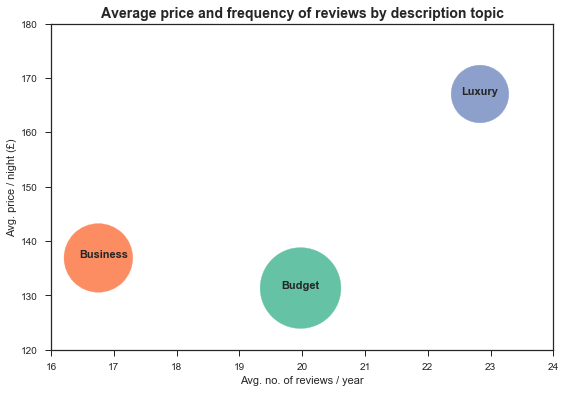

In [295]:
plt.figure(figsize=(9, 6))

# Unique category labels:
color_labels = df3['color'].unique()

# List of RGB triplets
rgb_values = sns.color_palette("Set2", 8)

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))

# Finally use the mapped values
plt.scatter(df3['reviews_per_year'], df3['price'], c=df3['color'].map(color_map), s=df3['count']*1.5)

plt.ylim([120,180])
plt.xlim([16,24])

plt.xlabel('Avg. no. of reviews / year')
plt.ylabel('Avg. price / night (£)')
plt.title('Average price and frequency of reviews by description topic', weight='bold', fontsize=14)

for i, txt in enumerate(df3.index):
    plt.annotate(txt, (df3['reviews_per_year'].iat[i]-0.3,df3['price'].iat[i]), fontsize=11, weight='bold')

NLP is an important feature of this project, and there are valuable insights produced from topic modelling in addition to improving predictive strength. By plotting a bubble chart of the 3 topics described in the earlier section of this report (Business, Budget and Luxury), it is possible to segment London's Airbnb market into the different topics, each of which demonstrating a different average price and frequency which are the component factors of yield.

In the below chart, each bubble is plotted at the average of that segment while the size represents the number of listings in that segment. Some of the characteristics of this chart make intuitive sense, while others are slightly more surprising. 

In terms of size, the 'Budget' segment has the most number of listings, followed by 'Business' while 'Luxury' has the least number of listings. This makes sense and one would expect there to naturally be more 'Budget' type listings available. 

Looking at the average price, 'Luxury' is the clear leader followed by 'Business' and 'Budget' at just £5-10 lower. While the order makes sense, what is surprising is the huge gap between the average price of 'Luxury' listings compared to the other 2 segments. This suggests that perhaps AirBnb listings cater to those looking for boutique stays and people in the 'Luxury' segment are more willing to pay for such an experience. On the other hand, business travellers on Airbnb would typically choose Airbnb for its lower price compared to hotels while traditional business travellers with a bigger budget might stick to hotels.

This trend is also supported by the number of reviews, which is a proxy for the frequency of bookings. There are comparatively very few 'Business' listings, further suggesting that most business travellers still shy away from AirBnb. On the other hand, 'Luxury' listings again stand out and prove that the appeal of AirBnb is in the unique experience of staying in a home that is popular among travellers looking for a higher quality and luxurious accommodation.

### Reflection
In this section, you will summarize the entire end-to-end problem solution and discuss one or two particular aspects of the project you found interesting or difficult. You are expected to reflect on the project as a whole to show that you have a firm understanding of the entire process employed in your work. Questions to ask yourself when writing this section:
- _Have you thoroughly summarized the entire process you used for this project?_
- _Were there any interesting aspects of the project?_
- _Were there any difficult aspects of the project?_
- _Does the final model and solution fit your expectations for the problem, and should it be used in a general setting to solve these types of problems?_

This project has been extremely rewarding to complete, giving me a challenging and interesting problem to explore and design my own solution for. Each stage of the project presented its own unique learning points a different part of the analytical toolkit to practice.

In the design phase, the focus was on researching and understanding the problem of predicting yield in AirBnb. What data is publicly available? What research has already been done? What are the implicit assumptions in the problem statement?

This led naturally onto the exploratory data analysis phase once I had gotten my hands on the right data set. To design the right solution, I had to thoroughly understand the data and quirks in it. This included understanding what the data points meant, how it was collected, and whether there might have been any unintended biases in the data. This also laid the foundation of understanding potential insights and hypotheses to test and what pre-processing might be necessary.

Iteratively, this also led to the data cleaning and manipulation stage. After understanding the data, I was able to perform the manipulations necessary such as imputing or removing missing values, feature selection, and calculating yield values.

Once the data has been cleaned and processed, I was able to fit them on the selected machine learning algorithms. The course syllabus was most useful here, and I began to appreciate the complexity of the different algorithms and how to interpret the results of each algorithm. By comparing the results I was able to choose a final cross-validated model and fine-tune it according to best practices.

After building the final model, it had to be thoroughly tested and evaluated. This included doing sensitivity analysis the test the robustness of the final solution, and sense checking the predictions and insights produced by the model.

One interesting aspect, and also the most challenging for me, was undertaking natural language processing for the feature engineering stage. I tested various techniques such as bag-of-words, term-frequency-inverse-document-frequency, latent Dirichlet allocation and also various regexes in the preprocessing stage. Ultimately, LDA proved to be the most powerful method of reducing the no. of dimensions and was able to give more interpretable topics compared to other topic modelling methods. 

The unique challenges in topic modelling stemmed from the more qualitive nature of text mining as opposed to working with numerical data. It is a lot more free-form and there is seldom a "right answer" to fall back to. For example, choosing the number of topics to model greatly affected the results. After testing several topic numbers, I decided to choose a relatively small number of 3. This kept the data manageable, the topics interpretable and also distinct enough to form insightful segments. Labelling the topics was another free-form challenge, though it was thankfully made easier by the ability to see word distributions in LDA. Though there is certainly no correct topic label, the word distributions and earlier EDA phase helped to suggest potential topic labels. I tried a few of these labels and tested them against the data set to see if they would make sense (e.g. the 'Budget' label should have a proportionaly lower price!). In the end, I was comfortable with the labels I settled on and there was a plausible story behind each topic label.

### Improvement
In this section, you will need to provide discussion as to how one aspect of the implementation you designed could be improved. As an example, consider ways your implementation can be made more general, and what would need to be modified. You do not need to make this improvement, but the potential solutions resulting from these changes are considered and compared/contrasted to your current solution. Questions to ask yourself when writing this section:
- _Are there further improvements that could be made on the algorithms or techniques you used in this project?_
- _Were there algorithms or techniques you researched that you did not know how to implement, but would consider using if you knew how?_
- _If you used your final solution as the new benchmark, do you think an even better solution exists?_

Looking back on the project, there have been numerous learnings and further improvements that could have been made.

As topic modelling was a big part of the project, a potential improvement would be to try and implement other topic modelling algorithms. While I focussed on LDA due to its interpretability, there were other algorithms such as Non-Negative Matrix Factorization that might have also led to good results. I could also have taken a more scientific approach to choosing the number of topics, and perhaps build a pipeline to iterate through a range of numbers to choose to optimal number with the highest predictive power.

Ultimately, I am happy with the end results and am convinced that the final solution is better than the benchmark initially established. Nevertheless, there will always be further improvements that can be made. 

What made this project unique was the attempt to use alternative data sources (in this case, text data) to improve predictive models of AirBnb yield. In a similar vein, AirBnb listings images could also be used as potential features. Attempting this would be quite complicated, requring an understanding of image recognition techniques but also the use of big data processing due to the amount of images one would need to analyse. Nevertheless, that would undoubtedly be an interesting next step to pursue.


-----------

**Before submitting, ask yourself. . .**

- Does the project report you’ve written follow a well-organized structure similar to that of the project template?
- Is each section (particularly **Analysis** and **Methodology**) written in a clear, concise and specific fashion? Are there any ambiguous terms or phrases that need clarification?
- Would the intended audience of your project be able to understand your analysis, methods, and results?
- Have you properly proof-read your project report to assure there are minimal grammatical and spelling mistakes?
- Are all the resources used for this project correctly cited and referenced?
- Is the code that implements your solution easily readable and properly commented?
- Does the code execute without error and produce results similar to those reported?